### Exact solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split

# Load the .mat file
mat_data = scipy.io.loadmat('Allen_Cahn.mat')

# Following is the code to plot the data u vs x and t. u is 256*100
# matrix. Use first 75 columns for training and 25 for testing :)

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['t']
u = mat_data['u']

# # Use the loaded variables as needed
# print(x.shape)
# print(t.shape)
# print(u.shape)

# X, T = np.meshgrid(x, t)
# # Define custom color levels
# c_levels = np.linspace(np.min(u), np.max(u), 100)

# # Plot the contour
# plt.figure()
# plt.figure(figsize=(15, 5))
# plt.contourf(T, X, u, levels=c_levels, cmap='coolwarm')
# plt.xlabel('t')
# plt.ylabel('x')
# plt.title('Allen-cahn-Equation')
# plt.colorbar()  # Add a colorbar for the contour levels
# plt.show()

### PINN data importing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split

# Load the .mat file
mat_data = scipy.io.loadmat('X.mat')

X = mat_data['X']

mat_data1 = scipy.io.loadmat('y_pred.mat')

u1 = mat_data1['y_pred']

np.set_printoptions(threshold=np.inf)

X.shape

(20301, 2)

In [3]:
### Reshaping the solution

u1 = u1.reshape(101, 201)
u1_new = u1.T


In [4]:
u1_new.shape

(201, 101)

In [5]:
# Load the .mat file
mat_data2 = scipy.io.loadmat('y_true.mat')

u2 = mat_data2['y_true']
print("tani", u2.shape)


tani (20301, 1)


In [6]:
# importing libaries

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [7]:
class LEMCell(nn.Module):
    def __init__(self, ninp, nhid, dt):
        super(LEMCell, self).__init__()
        self.ninp = ninp
        self.nhid = nhid
        self.dt = dt
        self.inp2hid = nn.Linear(ninp, 4 * nhid)
        self.hid2hid = nn.Linear(nhid, 3 * nhid)
        self.transform_z = nn.Linear(nhid, nhid)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.nhid)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, y, z):
        transformed_inp = self.inp2hid(x)
        transformed_hid = self.hid2hid(y)
        i_dt1, i_dt2, i_z, i_y = transformed_inp.chunk(4, 1)
        h_dt1, h_dt2, h_y = transformed_hid.chunk(3, 1)

        ms_dt_bar = self.dt * torch.sigmoid(i_dt1 + h_dt1)
        ms_dt = self.dt * torch.sigmoid(i_dt2 + h_dt2)

        z = (1. - ms_dt) * z + ms_dt * torch.tanh(i_y + h_y)
        y = (1. - ms_dt_bar) * y + ms_dt_bar * torch.tanh(self.transform_z(z) + i_z)

        return y, z

# Define the LEM model
class LEM(nn.Module):
    def __init__(self, ninp, nhid, nout, dt=1.):
        super(LEM, self).__init__()
        self.nhid = nhid
        self.cell = LEMCell(ninp, nhid, dt)
        self.classifier = nn.Linear(nhid, nout)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'classifier' in name and 'weight' in name:
                nn.init.kaiming_normal_(param.data)

    def forward(self, input):
        y = input.data.new(input.size(1), self.nhid).zero_()
        z = input.data.new(input.size(1), self.nhid).zero_()
        for x in input:
            y, z = self.cell(x, y, z)
        out = self.classifier(y)
        return out

In [8]:
# Toy problem data
input_size = 201  # number of columns in a dataset
hidden_size = 32  # number of neurons
output_size = 201
sequence_length = 80  # number of sequences/ number of rows
batch_size = 1
num_epochs = 200

In [9]:
# data = scipy.io.loadmat('y_pred.mat')
u1 = u1_new


In [10]:
input_data = u1[:, 0:80]
target_data = u1[:, 1:81]

test_data = u1[:, 80] ### Change here
#test_target = u1[:, 81:101]

print("test data shape", test_data.shape)
#print("test target shape", test_target.shape)

print("input data shape",input_data.shape)
print("Target data shape",target_data.shape)

test data shape (201,)
input data shape (201, 80)
Target data shape (201, 80)


In [11]:
# Convert data to tensors
input_tensor = torch.tensor(input_data.T).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data.T).view(batch_size, sequence_length, output_size).float()

print("input tensor shape",input_tensor.shape)
print("Target tensor shape",target_tensor.shape)

input tensor shape torch.Size([1, 80, 201])
Target tensor shape torch.Size([1, 80, 201])


In [12]:
# Convert test data to tensors
test_tensor = torch.tensor(test_data.T).view(batch_size, 1, input_size).float()
#test_target_tensor = torch.tensor(test_target.T).view(batch_size, 20, output_size).float()


In [13]:
# # dt=0.25, 0.15
lem = LEM(input_size, hidden_size, output_size, dt=0.25)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(lem.parameters(), lr=0.1)

# # Loss and optimizer
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(lem.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    def closure():
        optimizer.zero_grad()
        output = lem(input_tensor)
        loss = criterion(output, target_tensor)
        loss.backward()
        return loss

    optimizer.step(closure)

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {closure().item():.16f}')

    # Flatten prediction tensor
    prediction = lem(input_tensor).view(-1).detach().numpy()


/data/localhome/tkapoor/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 80, 201])) that is different to the input size (torch.Size([80, 201])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10/200, Loss: 0.0001880300260382
Epoch: 20/200, Loss: 0.0000316564801324
Epoch: 30/200, Loss: 0.0000155788675329
Epoch: 40/200, Loss: 0.0000056342300923
Epoch: 50/200, Loss: 0.0000039639339775
Epoch: 60/200, Loss: 0.0000036279138840
Epoch: 70/200, Loss: 0.0000036238811845
Epoch: 80/200, Loss: 0.0000036234071104
Epoch: 90/200, Loss: 0.0000036234071104
Epoch: 100/200, Loss: 0.0000036234071104
Epoch: 110/200, Loss: 0.0000036234071104
Epoch: 120/200, Loss: 0.0000036234071104
Epoch: 130/200, Loss: 0.0000036234071104
Epoch: 140/200, Loss: 0.0000036234071104
Epoch: 150/200, Loss: 0.0000036234071104
Epoch: 160/200, Loss: 0.0000036234071104
Epoch: 170/200, Loss: 0.0000036234071104
Epoch: 180/200, Loss: 0.0000036234071104
Epoch: 190/200, Loss: 0.0000036234071104
Epoch: 200/200, Loss: 0.0000036234071104


In [14]:
print(test_tensor.shape)
prediction_tensor = torch.zeros(1, 20, 201).float()
print(prediction_tensor.shape)

torch.Size([1, 1, 201])
torch.Size([1, 20, 201])


torch.Size([1, 1, 201])
(201, 1)
(201, 1)


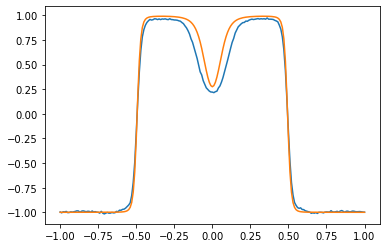

In [15]:
with torch.no_grad():
    prediction = lem(test_tensor)
    prediction = prediction.view(1, 1, 201).float()
    prediction_tensor[:, 0, :] = prediction
    for i in range(19):
        prediction = lem(prediction)
        prediction = prediction.view(1, 1, 201).float()
        prediction_tensor[:, i+1, :] = prediction
        
print(prediction.shape)

final_out = prediction.detach().numpy().reshape(-1,1)
final_true = u[-1,:].reshape(-1,1)

print(final_out.shape)
print(final_true.shape)

x = x.reshape(-1, 1)

plt.plot(x, final_out)
plt.plot(x, final_true)
plt.show()

### error at final time

In [16]:
# Convert NumPy arrays to PyTorch tensors
final_out_tensor = torch.from_numpy(final_out)
final_true_tensor = torch.from_numpy(final_true)
# final_true_tensor = torch.abs(final_true_tensor)

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((final_out_tensor - final_true_tensor)**2)/torch.mean(final_true_tensor**2)
print("Relative Error Test: ", relative_error_test.item(), "")

Relative Error Test:  0.009723107556742374 


### Error in whole testing dataset

In [17]:
# exact
u_test = u
u_test_full = u_test[80:100, :]

In [18]:
u_test_full.shape

(20, 201)

In [19]:
prediction_tensor.shape

torch.Size([1, 20, 201])

### L2 norm 

### Changed prediction tensor

In [20]:

k1 = (prediction_tensor - u_test_full)**2
u_test_full_tensor = torch.tensor(u_test_full**2)
u_test_full_tensor.shape

torch.Size([20, 201])

In [21]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(k1)/ torch.mean(u_test_full_tensor)

print("Relative Error Test: ", relative_error_test.item(), "%")

Relative Error Test:  0.0029508101568068304 %


### Max absolute error

In [22]:
R_abs = torch.max(prediction-u_test_full)

In [23]:
R_abs

tensor(0.1362, dtype=torch.float64)

### mean absolute error

In [24]:
R_mean = torch.mean(torch.abs(prediction - u_test_full))

In [25]:
R_mean

tensor(0.0282, dtype=torch.float64)

### Explained variance error

In [26]:
import torch

a = prediction
b = u_test_full
# Assuming 'a' is your predicted values (model's predictions) and 'b' is the true values (ground truth)
# Make sure 'a' and 'b' are PyTorch tensors
b = torch.tensor(b)
# Calculate the mean of 'b'
mean_b = torch.mean(b)

# Calculate the Explained Variance Score
numerator = torch.var(b - a)  # Variance of the differences between 'b' and 'a'
denominator = torch.var(b)    # Variance of 'b'
evs = 1 - numerator / denominator

print("Explained Variance Score:", evs.item())


Explained Variance Score: 0.9969839761866542


### Contour plot 80 PINN and 20 LEM solution

In [27]:
prediction_tensor = torch.squeeze(prediction_tensor)
prediction_tensor.shape

torch.Size([20, 201])

In [28]:
prediction.shape

torch.Size([1, 1, 201])

In [29]:
input_tensor.shape

torch.Size([1, 80, 201])

In [30]:
conc_u = torch.squeeze(input_tensor)
prediction_tensor = torch.squeeze(prediction_tensor)

In [31]:
concatenated_tensor = torch.cat((conc_u, prediction_tensor), dim=0)

concatenated_tensor.shape

torch.Size([100, 201])

In [32]:
t1 = np.linspace(0, 1 , 100)

#### Snapshots at particular time
### t = 0.81, 0.99

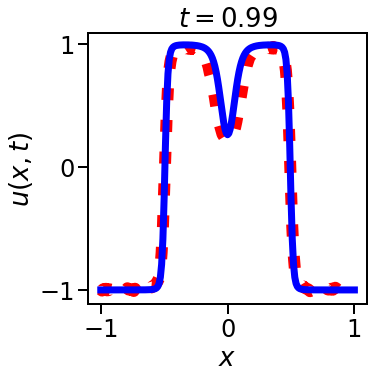

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed

# # Make sure the font is Times Roman
# plt.rcParams['font.family'] = 'Times New Roman'

# # Perform the prediction
# with torch.no_grad():
#     prediction = lem(test_tensor)

final_time_output = prediction_tensor[-2, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u[-2, :].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=7, label='True')

# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 0.99}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)


# Increase font size for x and y axis numbers
ax.tick_params(axis='both', which='major', labelsize=24)

# Set the legend
# ax.legend()

plt.savefig('LEM_0.99_20.pdf', dpi=500, bbox_inches="tight")

# Show the plot
plt.show()


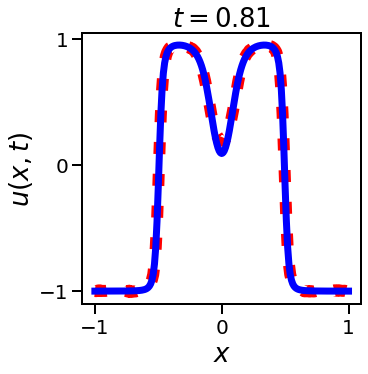

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed

# Make sure the font is Times Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Perform the prediction
with torch.no_grad():
    prediction = lem(test_tensor)

final_time_output = prediction_tensor[-20, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u[-20, :].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=7, label='True')

# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 0.81}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Set the legend
# ax.legend()

plt.savefig('LEM_0.81_20.pdf', dpi=500, bbox_inches="tight")

# Show the plot
plt.show()


### 80-20 (80 for PINN and 20 extrapolation using LEM)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


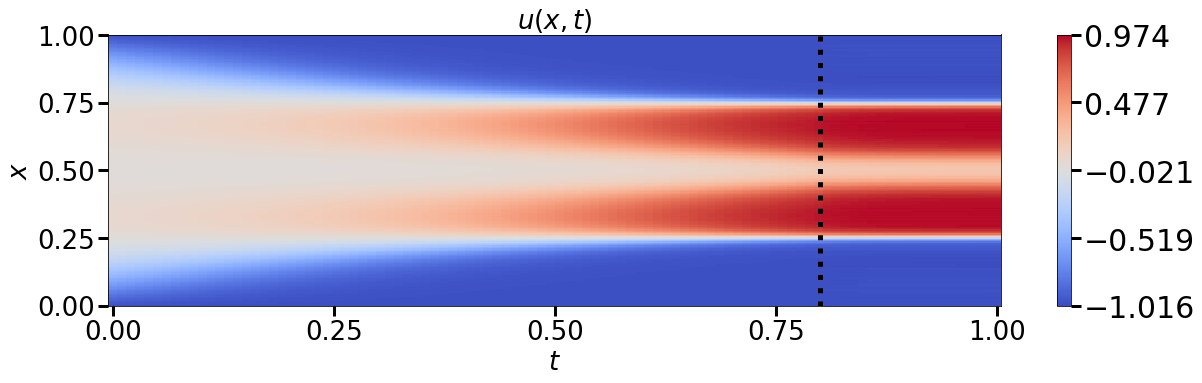

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = concatenated_tensor.numpy()

# Define custom color levels
x = np.linspace(0, 1, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(0, 1, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x, t1)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='coolwarm')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$t$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$u(x, t)$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

# Add a dotted line at t = 0.8
plt.axvline(x=0.8, color='black', linestyle='dotted', linewidth=5)

#plt.savefig('Contour_LEM_20.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_LEM_20.jpeg', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


### exact solution contour

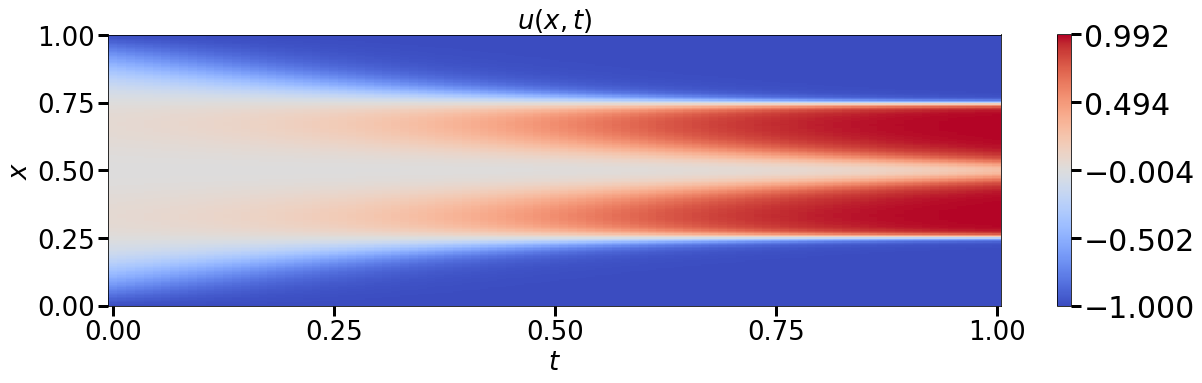

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = u

# Define custom color levels
x = np.linspace(0, 1, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(0, 1, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x, t)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='coolwarm')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$t$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$u(x, t)$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

#plt.savefig('Contour_Exact.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_exact.jpeg', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()
